In [1]:
import numpy as np
import extq
import matplotlib.pyplot as plt
from matplotlib import ticker
import pyemma
import glob
import sys
import importlib
import gc
import sklearn
from sklearn import metrics
import ivac
import seaborn as sns

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting
import kde

In [3]:
plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

# Load data

In [4]:
cv_trajs = np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
suppl_cvs = np.load("../../data/raw_feat/cv_dist_spin_suppl_00.npy", allow_pickle=True)
cv_trajs = [*cv_trajs, *suppl_cvs]

In [5]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [6]:
remove = [
    1282,
    1283,
    1284,
    1285,
    1286,
    1288,
    1289,
    1290,
    1187,
    1188,
    1189,
    1190,
    1191,
    1197,
    1198,
    1199,
    1203,
    1205,
    1206,
    1207,
    1211,
    1212,
    1213,
    1214,
    1215,
    1225,
    1226,
    1227,
    1228,
    1231,
    1232,
    1233,
    1236,
    1237,
    1238,
    1242,
    1245,
    1246,
    1252,
    1253,
    1260,
    1261,
    1262,
    1263,
    1266,
    1267,
    1268,
    1269,
    1270,
    1271,
    1272,
    1273,
    1274,
    1275,
    1276,
    1277,
    1278,
    1279,
]

In [7]:
sb_trajs = np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True)
sb_trajs = [
    *sb_trajs,
    *np.load("../../data/raw_feat/feat2_suppl_00.npy", allow_pickle=True),
    *np.load("../../data/raw_feat/feat2_suppl_01.npy", allow_pickle=True),
    *np.load("../../data/raw_feat/feat2_suppl_02.npy", allow_pickle=True),
    *np.load("../../data/raw_feat/feat2_suppl_03.npy", allow_pickle=True),
]

In [8]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(3432000, 2) (3432000, 60)


In [9]:
ivac_trajs = np.load("../../data/raw_feat/feat5_ivac_suppl.npy", allow_pickle=True)

In [10]:
print(len(ivac_trajs), ivac_trajs[-1].shape)

381 (3000, 10)


In [11]:
ivac_arr = np.concatenate(ivac_trajs)

In [12]:
ivac_arr.shape

(3432000, 10)

# Delay embed data

In [13]:
n_embed = 20  # number of embeddings deep
lag = 10  # 1 ns
# use smaller input feature set
# R223-D129, R226-D129, R226-D186, R229-D129, R229-D186, R232-D186
sb_ids = [36, 42, 47, 48, 53, 59]
data_orig = [traj[:, sb_ids] for traj in sb_trajs]
embed_trajs = util.delay_embed(data_orig, n_embed, lag)
embed_arr = np.concatenate(embed_trajs)

print(data_orig[0].shape)
print(len(embed_trajs), embed_trajs[0].shape)
print(embed_arr.shape)

(10000, 6)
381 (9800, 126)
(3355800, 126)


In [14]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
# tic1 = livac_arr[:, 1]
# tic2 = livac_arr[:, 2]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = (
    ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)
).nonzero()[0]

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
).nonzero()[0]

In [15]:
traj_inds = []
curr = 0
for traj in cv_trajs[:-1]:
    curr += len(traj)
    traj_inds.append(curr)

In [18]:
# len(**_ids) is number of points in each state
# split into lists of trajectories
down = np.zeros(len(cv_arr), dtype=np.float64)
down[down_ids] = True
down = np.split(down, traj_inds)
up = np.zeros(len(cv_arr), dtype=np.float64)
up[up_ids] = True
up = np.split(up, traj_inds)

In [19]:
# delay embed indicator functions for states
lifted_up = util.lift_function(up, n_embed, lag=lag)
lifted_down = util.lift_function(down, n_embed, lag=lag)
print(len(lifted_up), lifted_up[0].shape)
print(len(lifted_down), lifted_down[0].shape)

381 (9800,)
381 (9800,)


In [20]:
len(up_ids), len(down_ids)

(6649, 33430)

In [21]:
# lift CV data
lifted_cvs = util.lift_function(cv_trajs, n_embed, lag=lag)
lifted_sbs = util.lift_function(sb_trajs, n_embed, lag=lag)
print(len(lifted_cvs), lifted_cvs[0].shape)
print(len(lifted_sbs), lifted_sbs[0].shape)

381 (9800, 2)
381 (9800, 60)


In [22]:
lifted_cv_arr = np.concatenate(lifted_cvs)
lifted_sb_arr = np.concatenate(lifted_sbs)
print(lifted_cv_arr.shape, lifted_sb_arr.shape)

(3355800, 2) (3355800, 60)


In [23]:
lifted_ivac = util.lift_function(ivac_trajs, n_embed, lag=lag)
lifted_ivac_arr = np.concatenate(lifted_ivac)
print(lifted_ivac_arr.shape)

(3355800, 10)


In [24]:
lifted_traj_lens = [len(traj) for traj in embed_trajs]
lifted_traj_inds = []
subtot = 0
for length in lifted_traj_lens[:-1]:
    subtot += length
    lifted_traj_inds.append(subtot)

# new up and upplus ids
up_arr = np.concatenate(lifted_up)
up_ids_lifted = up_arr.nonzero()[0]
down_arr = np.concatenate(lifted_down)
down_ids_lifted = down_arr.nonzero()[0]

# states in data
up_data = embed_arr[up_ids_lifted]
down_data = embed_arr[down_ids_lifted]
print(len(up_data), len(down_data))

5999 32122


## states

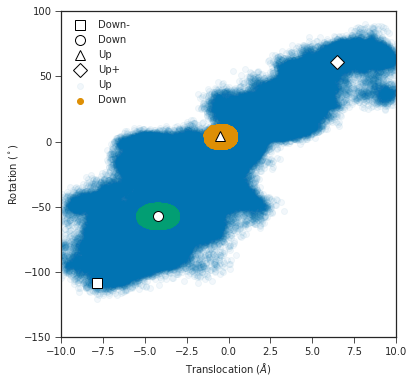

In [26]:
s = 10
f, ax = plt.subplots(figsize=(6, 6))
plt.scatter(lifted_cv_arr[::s, 0], lifted_cv_arr[::s, 1], alpha=0.05)
plt.scatter(*lifted_cv_arr[up_ids_lifted].T)
plt.scatter(*lifted_cv_arr[down_ids_lifted].T)
plotting.format_cvs(ax, centroids=True)
plt.legend(["Down-", "Down", "Up", "Up+", "Up", "Down"])

# Pairwise distances

In [27]:
from sklearn.metrics import pairwise_distances_chunked

In [28]:
# compute minimum distance (minimum of column) from domain to dimeric/monomeric state
def reduce_func(D_chunk, start):
    min2 = np.min(D_chunk, axis=1)
    return min2

### Up state 

In [29]:
d_up = []
counter = 0.0
tot = len(embed_arr)
skip = 1

for chunk in pairwise_distances_chunked(
    embed_arr, up_data[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_up.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.67% completed
1.33% completed
2.00% completed
2.67% completed
3.33% completed
4.00% completed
4.67% completed
5.33% completed
6.00% completed
6.67% completed
7.33% completed
8.00% completed
8.67% completed
9.33% completed
10.00% completed
10.67% completed
11.33% completed
12.00% completed
12.67% completed
13.33% completed
14.00% completed
14.67% completed
15.33% completed
16.00% completed
16.67% completed
17.33% completed
18.00% completed
18.67% completed
19.33% completed
20.00% completed
20.67% completed
21.33% completed
22.00% completed
22.67% completed
23.33% completed
24.00% completed
24.67% completed
25.33% completed
26.00% completed
26.67% completed
27.33% completed
28.00% completed
28.67% completed
29.33% completed
30.00% completed
30.67% completed
31.33% completed
32.00% completed
32.67% completed
33.33% completed
34.00% completed
34.67% completed
35.33% completed
36.00% completed
36.67% completed
37.34% completed
38.00% completed
38.67% completed
39.34% completed
40.00% comp

In [30]:
print(len(d_up), d_up[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_up_arr = np.reshape(np.concatenate(d_up), (-1, 1))
print(d_up_arr.shape)
print(np.max(d_up_arr[up_ids_lifted]))
d_up_arr[up_ids_lifted] = 0
print(np.max(d_up_arr[up_ids_lifted]))

print(d_up_arr.shape)

150 (22373,)
(3355800, 1)
3.1539813e-07
0.0
(3355800, 1)


In [31]:
np.save("../../data/delay_embed/sb6_1ns_20embed_suppl/dist_up_du.npy", d_up_arr)

### Down state

In [33]:
d_down = []
counter = 0.0

for chunk in pairwise_distances_chunked(
    embed_arr, down_data[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_down.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.12% completed
0.25% completed
0.37% completed
0.50% completed
0.62% completed
0.75% completed
0.87% completed
1.00% completed
1.12% completed
1.25% completed
1.37% completed
1.49% completed
1.62% completed
1.74% completed
1.87% completed
1.99% completed
2.12% completed
2.24% completed
2.37% completed
2.49% completed
2.61% completed
2.74% completed
2.86% completed
2.99% completed
3.11% completed
3.24% completed
3.36% completed
3.49% completed
3.61% completed
3.74% completed
3.86% completed
3.98% completed
4.11% completed
4.23% completed
4.36% completed
4.48% completed
4.61% completed
4.73% completed
4.86% completed
4.98% completed
5.10% completed
5.23% completed
5.35% completed
5.48% completed
5.60% completed
5.73% completed
5.85% completed
5.98% completed
6.10% completed
6.23% completed
6.35% completed
6.47% completed
6.60% completed
6.72% completed
6.85% completed
6.97% completed
7.10% completed
7.22% completed
7.35% completed
7.47% completed
7.59% completed
7.72% completed
7.84% co

In [36]:
print(len(d_down), d_down[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_down_arr = np.reshape(np.concatenate(d_down), (-1, 1))

print(np.max(d_down_arr[down_ids_lifted]))
d_down_arr[down_ids_lifted] = 0
assert np.max(d_down_arr[down_ids_lifted]) == 0

print(d_down_arr.shape)

804 (4178,)
5.0576216e-07
(3355800, 1)


In [37]:
np.save("../../data/delay_embed/sb6_1ns_20embed_suppl/dist_down_du.npy", d_down_arr)

# Basis

In [38]:
# make smoothing function
smooth = (d_up_arr * d_down_arr) ** 0.5 / (d_up_arr + d_down_arr)

# make guess
guess_up = (d_down_arr ** 2) / (d_up_arr ** 2 + d_down_arr ** 2)
guess_down = (d_up_arr ** 2) / (d_up_arr ** 2 + d_down_arr ** 2)

# make smoothing 0 at boundaries (up and down states)
mask = np.ones(len(embed_arr), dtype=bool)
mask[up_ids_lifted] = False
mask[down_ids_lifted] = False
smooth[(mask == 0).flatten()] = 0

# ensure homogeneous boundary conditions for guess
guess_up[up_ids_lifted] = 1
guess_up[down_ids_lifted] = 0
guess_down[down_ids_lifted] = 1
guess_down[up_ids_lifted] = 0

In [39]:
print(smooth.shape, guess_up.shape, guess_down.shape)

(3355800, 1) (3355800, 1) (3355800, 1)


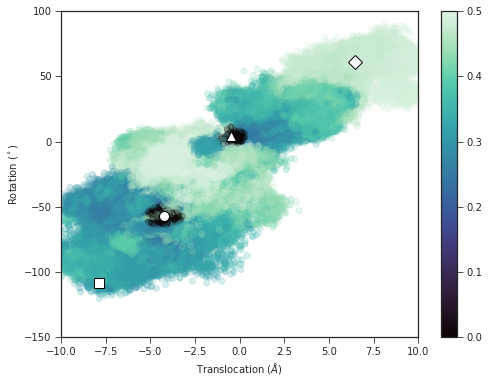

In [41]:
# Plot smoothing function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    lifted_cv_arr[::10, 0],
    lifted_cv_arr[::10, 1],
    c=smooth[::10],
    alpha=0.2,
    cmap="mako",
)
cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1)
plotting.format_cvs(ax, centroids=True)

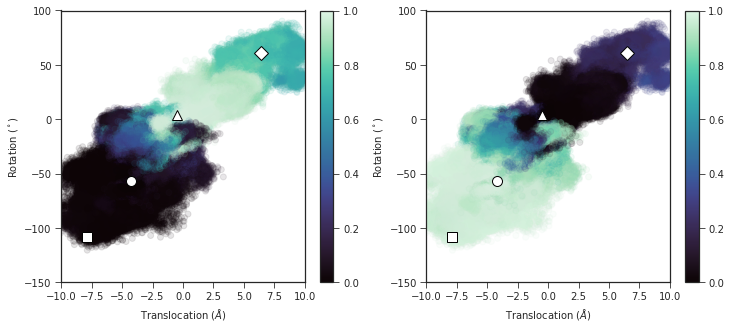

In [44]:
# Plot up and down state guess function
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for ax, guess in zip(axs, (guess_up, guess_down)):
    h = ax.scatter(
        lifted_cv_arr[::10, 0],
        lifted_cv_arr[::10, 1],
        c=guess[::10],
        alpha=0.1,
        cmap="mako",
    )
    cb = plt.colorbar(h, ax=ax)
    cb.solids.set(alpha=1)
    plotting.format_cvs(ax, centroids=True)
f.tight_layout()

In [46]:
def svd_whiten(X, num_retain=None):
    U, L, V = np.linalg.svd(X, full_matrices=False)
    if num_retain is None:
        return U
    else:
        return U[:, :num_retain]

In [47]:
basis_smooth = smooth * embed_arr
print(basis_smooth.shape)
# basis_white, L = util.svd_whiten(basis_smooth, 1, frac_retain=1.)
basis_white = svd_whiten(basis_smooth)
basis_white[(mask == 0).flatten()] = 0
print(basis_white.shape)

(3355800, 126)
(3355800, 126)


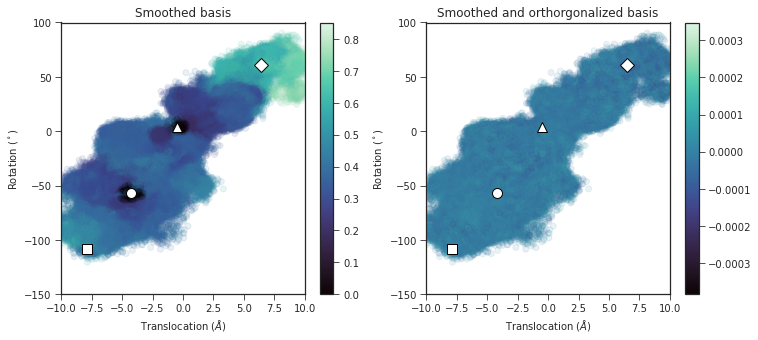

In [49]:
# Plot bases
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for ax, b in zip(axs, (basis_smooth, basis_white)):
    h = ax.scatter(
        lifted_cv_arr[::10, 0],
        lifted_cv_arr[::10, 1],
        c=np.mean(b[::10], axis=1),
        alpha=0.1,
        cmap="mako",
    )
    cb = plt.colorbar(h, ax=ax)
    cb.solids.set(alpha=1)
    plotting.format_cvs(ax, centroids=True)
axs[0].set_title("Smoothed basis")
axs[1].set_title("Smoothed and orthorgonalized basis")
f.tight_layout()

In [50]:
basisF = np.split(basis_white, lifted_traj_inds)
guessD = np.split(np.squeeze(guess_down), lifted_traj_inds)
guessU = np.split(np.squeeze(guess_up), lifted_traj_inds)

print(len(basisF), basisF[0].shape)
print(len(guessD))
print(len(guessU))

381 (9800, 126)
381
381


## weights 

In [51]:
# unit is 0.1 ps, up to 500 ns
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

In [52]:
weights = []
for lag in lags:
    print(f"Computing change of measure for lag {lag}")
    com = extq.dga.reweight(embed_trajs, lag)
    weights.append(com)

Computing change of measure for lag 1
Computing change of measure for lag 2
Computing change of measure for lag 5
Computing change of measure for lag 10
Computing change of measure for lag 20
Computing change of measure for lag 50
Computing change of measure for lag 100
Computing change of measure for lag 200
Computing change of measure for lag 500
Computing change of measure for lag 1000
Computing change of measure for lag 2000
Computing change of measure for lag 5000


In [53]:
np.save("../../data/delay_embed/sb6_1ns_20embed_suppl/coms", weights)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# Committors

In [54]:
in_domain = np.split(mask, lifted_traj_inds)
in_domain[0].shape

(9800,)

In [56]:
q_downup = []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basisF, com, in_domain, guessU, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 500
Calculating committors for lag 1000
Calculating committors for lag 2000
Calculating committors for lag 5000


In [58]:
np.save("../../data/delay_embed/sb6_1ns_20embed_suppl/q_downup", q_downup)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## all lags

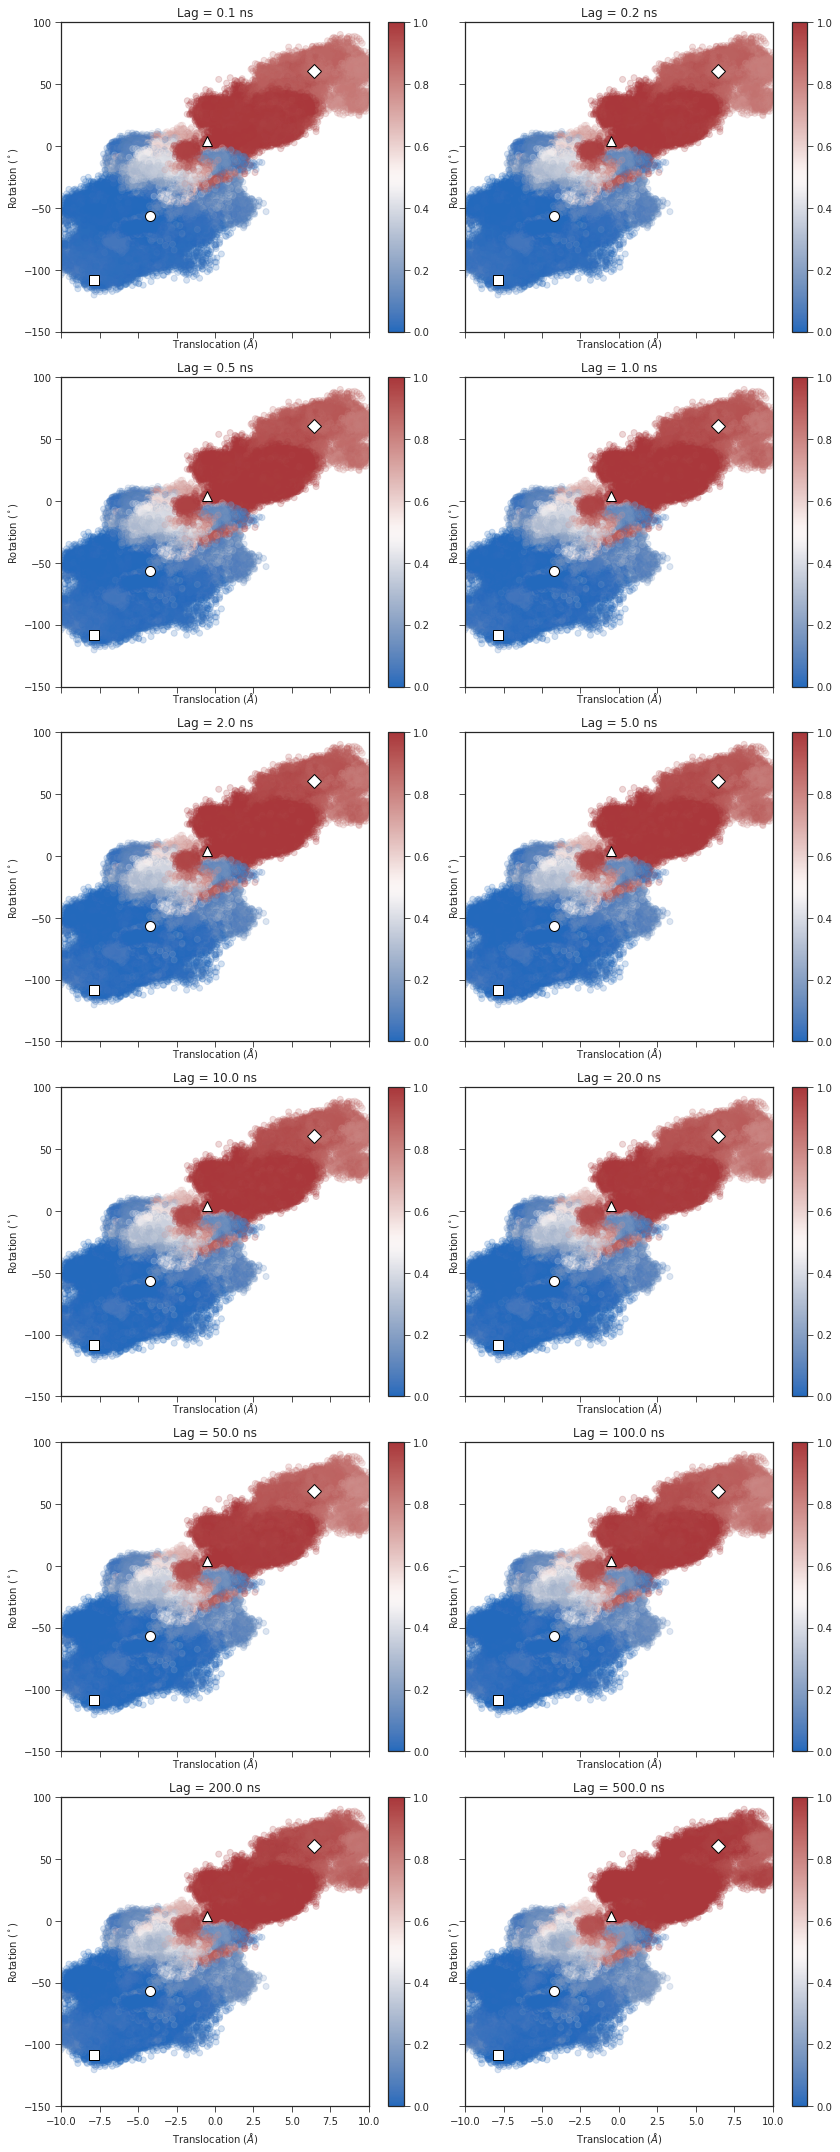

In [59]:
f, axs = plt.subplots(6, 2, figsize=(12, 30), sharex=True, sharey=True)
for lag, q, ax in zip(lags, q_downup, axs.flatten()):
    q_arr = np.concatenate(q).clip(min=0.0, max=1.0)
    h = ax.scatter(*lifted_cv_arr[::s].T, c=q_arr[::s], cmap="vlag", alpha=0.2)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    plotting.format_cvs(ax, centroids=True)
f.tight_layout()

## Salt bridges

In [61]:
from itertools import combinations

In [64]:
sb_ids = [42, 48, 47, 53]

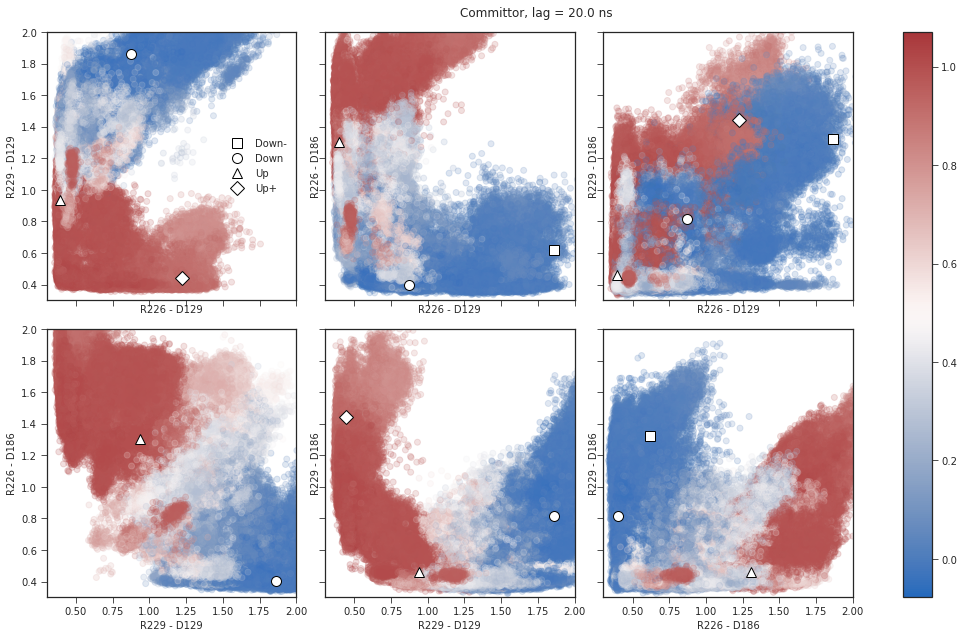

In [65]:
f, axes = plt.subplots(2, 3, figsize=(15, 9), sharex=True, sharey=True)

s = 10
q_arr = np.concatenate(q_downup[7])
for ((sb1, sb2), ax) in zip(combinations(sb_ids, 2), axes.flat):
    h = ax.scatter(
        lifted_sb_arr[::s, sb1],
        lifted_sb_arr[::s, sb2],
        c=q_arr[::s],
        cmap="vlag",
        alpha=0.2,
    )
    ax.set(
        xlabel=sb_labels[sb1 - 30],
        ylabel=sb_labels[sb2 - 30],
        xlim=[0.3, 2.0],
        ylim=[0.3, 2.0],
    )
plt.suptitle(f"Committor, lag = {lags[7] * 0.1} ns")
f.tight_layout()

cbar = f.colorbar(h, ax=axes.ravel().tolist())
cbar.solids.set(alpha=1)

plotting.plot_sb_models(axes.flat, mode="du", centroids=True)
axes[0][0].legend(["Down-", "Down", "Up", "Up+"], loc="right")